In [14]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import h5py
from sklearn.model_selection import train_test_split

## Task 1: CNNs for Galaxy Classification

In [3]:
# create data folder if it does not exist
import os
os.makedirs("data", exist_ok=True)

import urllib.request
_, msg = urllib.request.urlretrieve(
    "http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", 
    "data/Galaxy10.h5"
)

In [6]:
label_names = [
    'Disk, Face-on, No Spiral',
    'Smooth, Completely round',
    'Smooth, in-between round',
    'Smooth, Cigar shaped',
    'Disk, Edge-on, Rounded Bulge',
    'Disk, Edge-on, Boxy Bulge',
    'Disk, Edge-on, No Bulge',
    'Disk, Face-on, Tight Spiral',
    'Disk, Face-on, Medium Spiral',
    'Disk, Face-on, Loose Spiral'
]
n_classes = len(label_names)

# To get the images and labels from file
with h5py.File('data/Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
images = images.astype(np.float32)

# comply to (batch, channel, height, width) convention of pytorch
images = np.moveaxis(images, -1, 1)  
# convert to torch
images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

print(f'{images.shape=}, {labels.shape=}')

images.shape=torch.Size([21785, 3, 69, 69]), labels.shape=torch.Size([21785])


### (a)

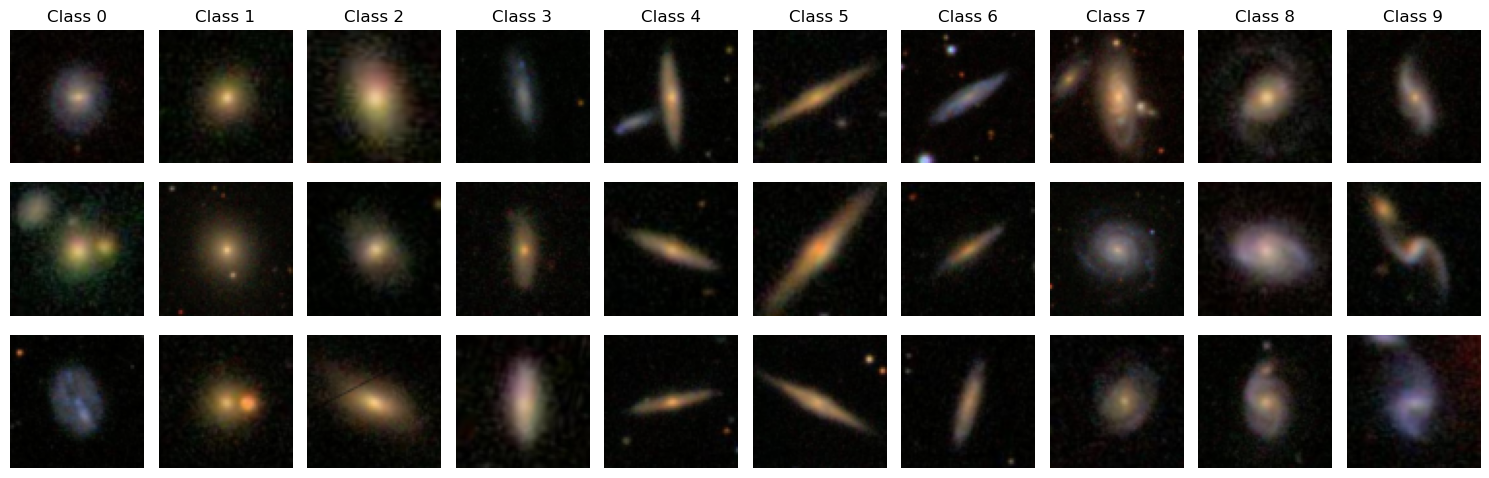

In [7]:
# TODO: plot three samples of each class
def visualize_data(images, labels):
    fig, axes = plt.subplots(3, 10, figsize=(15, 5))
    unique_classes = torch.unique(labels)
    for i, class_id in enumerate(unique_classes):
        class_images = images[labels == class_id]
        for j in range(3):
            axes[j, i].imshow(class_images[j].permute(1, 2, 0).numpy().astype(int))
            axes[j, i].axis("off")
            if j == 0:
                axes[j, i].set_title(f"Class {class_id.item()}")
    plt.tight_layout()
    plt.show()

visualize_data(images, labels)

For normalization the mean and the standard deviation across the whole train dataset for each channel is calculated.

In [20]:
from torchvision.transforms import Normalize

# TODO: Normalize the images
# TODO: Split the data and create tensordatasets and data loaders:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

means = torch.mean(X_train, axis=(0,2,3))
stds =  torch.std(X_train,axis=(0,2,3))
normalize_transform = Normalize(means,stds)

X_train = normalize_transform(X_train)
X_val = normalize_transform(X_val)
X_test = normalize_transform(X_test)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### (b)

In [30]:
#TODO: implement a small CNN as specified on the sheet
from torch import nn
import torch.nn.functional as F

class GalaxyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)  
        self.pool = nn.MaxPool2d(2, 2)  
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)  
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 14 * 14, 64) # 14 is dimension size after last pooling
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 

### (c) + (d) + (e)

Cross Entropy Loss is the loss of choice for multi-class classification.

In [36]:
import torch.optim as optim
# TODO: Instantiate the model, optimizer and criterion
model = GalaxyCNN()

# optimizer = ?
# criterion = ?
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

# TODO: Implement the training loop, validating after every epoch, and make the requested plots.

def validate(model,val_loader):
    losses = []
    correct = 0
    total = 0

    #TODO: Implement the validation loop
    model.eval()
    with torch.no_grad(): 
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = np.mean(np.array(losses))
    accuracy = correct / total
    print(f'{accuracy=:.2f}, {avg_loss=:.2e}')
    return avg_loss, accuracy

val_loss, val_acc = validate(model,val_loader)
val_losses.append(val_loss)
val_accs.append(val_acc)
num_epochs = 30
best_val_loss = float('inf') 
best_model_wts = None
for epoch in range(num_epochs):
    # TODO: Implement the training loop, validating after every epoch and a visialization of the loss curves
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accs.append(train_accuracy)

    val_loss, val_acc = validate(model, val_loader)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.2e}, Validation Loss: {val_loss:.2e}, Validation Accuracy: {val_acc:.2f}")

accuracy=0.06, avg_loss=2.39e+00
accuracy=0.56, avg_loss=1.13e+00
Epoch 1/30, Training Loss: 1.37e+00, Validation Loss: 1.13e+00, Validation Accuracy: 0.56
accuracy=0.66, avg_loss=9.95e-01
Epoch 2/30, Training Loss: 9.68e-01, Validation Loss: 9.95e-01, Validation Accuracy: 0.66
accuracy=0.69, avg_loss=9.14e-01
Epoch 3/30, Training Loss: 8.28e-01, Validation Loss: 9.14e-01, Validation Accuracy: 0.69
accuracy=0.70, avg_loss=9.09e-01
Epoch 4/30, Training Loss: 7.58e-01, Validation Loss: 9.09e-01, Validation Accuracy: 0.70
accuracy=0.71, avg_loss=8.75e-01
Epoch 5/30, Training Loss: 7.04e-01, Validation Loss: 8.75e-01, Validation Accuracy: 0.71
accuracy=0.73, avg_loss=8.36e-01
Epoch 6/30, Training Loss: 6.72e-01, Validation Loss: 8.36e-01, Validation Accuracy: 0.73
accuracy=0.72, avg_loss=8.03e-01
Epoch 7/30, Training Loss: 6.24e-01, Validation Loss: 8.03e-01, Validation Accuracy: 0.72
accuracy=0.74, avg_loss=7.77e-01
Epoch 8/30, Training Loss: 5.95e-01, Validation Loss: 7.77e-01, Validatio

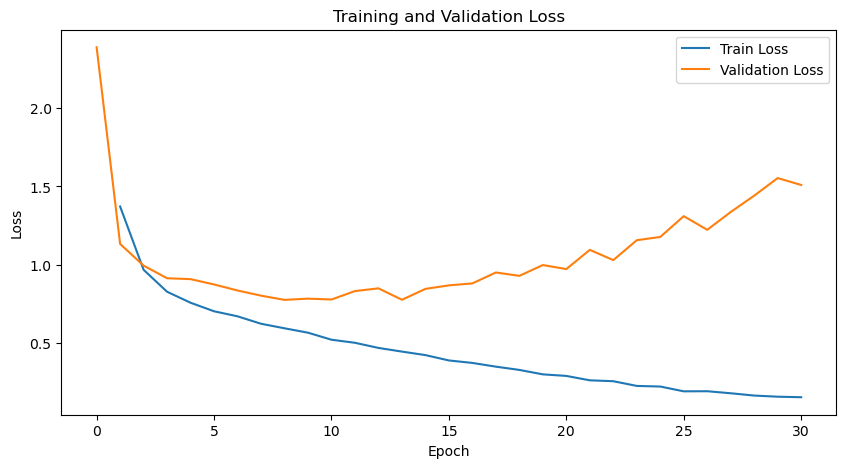

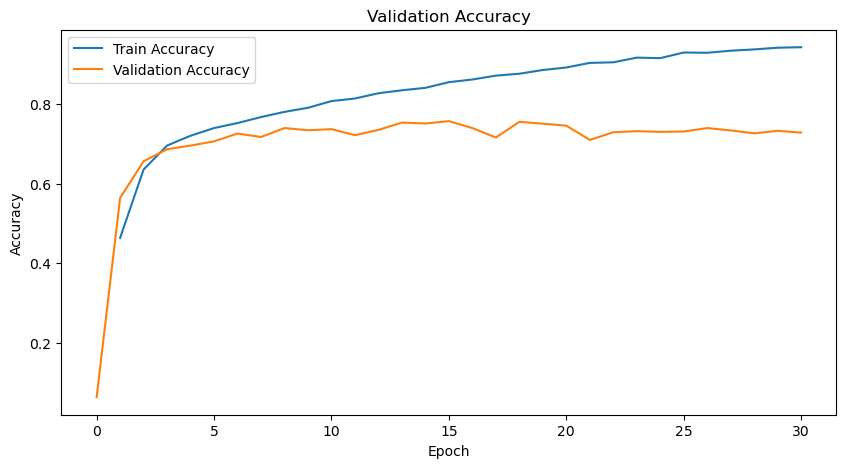

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 31), train_losses, label='Train Loss')
plt.plot(range(0, 31), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, 31), train_accs, label='Train Accuracy')
plt.plot(range(0, 31), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

The model tends to overfit. Taking an earlier checkpoint reduces the problem. Better results can be achieved with regularization or larger datasets.

### (e)

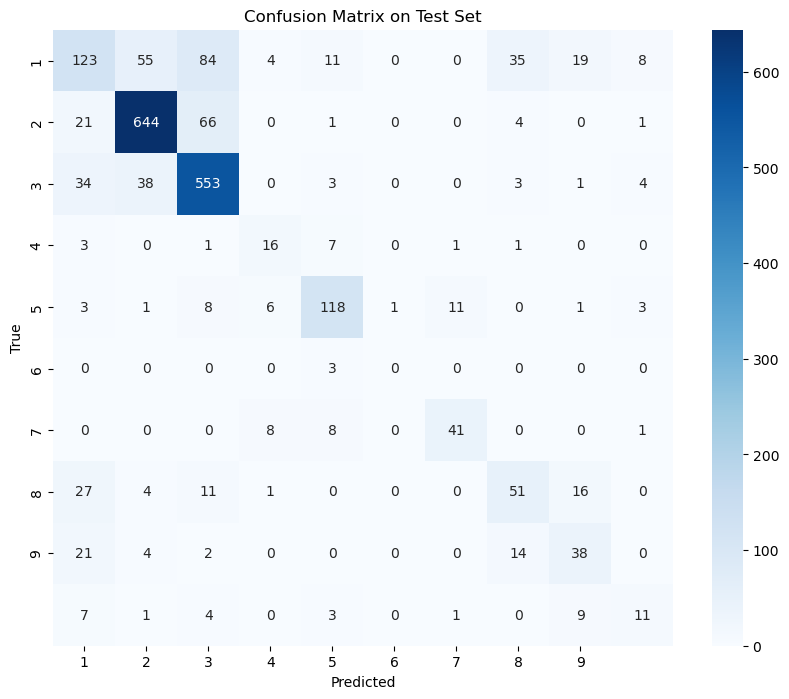

In [40]:
# TODO: Evaluate the best validation model on the test set and create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


model.load_state_dict(best_model_wts)
def evaluate_on_test_set(model, test_loader):
    model.eval()  
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    cm = confusion_matrix(y_true, y_pred)
    return cm

cm = evaluate_on_test_set(model, test_loader)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 10), yticklabels=np.arange(1, 10))
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### (f)
Invariance under rotations can be achieved by augmentation of the training set with rotation. Another approach is to use group invariant CNNs, where the convolutions are eqivariant to groups as rotations.

## 3 Positional Encoding

$ E \in \mathbb{R}^{p\times n} $

$ E_{(2k), i} = \sin\left(i \cdot \exp\left(-\frac{2k \cdot \log(10000)}{p}\right)\right) $

$ E_{(2k+1), i} = \cos\left(i \cdot \exp\left(-\frac{2k \cdot \log(10000)}{p}\right)\right) $